# How to generate quickly a simulated timeline and produce a map with `litebird_sim`

**Attention! This notebook can work only after having downloaded the Litebird IMO information.**

You will have to ask the permission to access the private repository https://github.com/litebird/litebird_imo and then install it following [the documentation](https://litebird-sim.readthedocs.io/en/master/tutorial.html#interacting-with-the-imo).

To run this notebook, you should create and activate a new virtual environment with the commands

```
python -m venv ./my_venv
source ./my_venv/bin/activate
```

(you can use Conda environments, if you prefer) and install Jupyter and litebird_sim in it:

```
pip install jupyter litebird_sim
```

If you have a local copy of the `litebird_sim` repository cloned from <https://github.com/litebird/litebird_sim> (e.g., because you're part of the Simulation Team!), you can use a *development install* instead:

```
cd /my/local/copy/litebird_sim
pip install -e .
```

## Set up the environment

We start by importing a few libraries that will be useful in this notebook.

In [1]:
import litebird_sim as lbs
import numpy as np
import matplotlib.pylab as plt
import healpy as hp
from astropy.time import Time

%matplotlib inline

TOAST INFO: mpi4py not found- using serial operations only


# Produce a simualted timeline


We will simulate 4 detectors of 140 GHz MFT. Their definition will be taken from the LiteBIRD Instrument MOdel (IMO) version 1.3 (**new!**), and we will simulate 2 hours of observation. See the [documentation](https://litebird-sim.readthedocs.io/en/latest/simulations.html#simulations) for more details about the input parameters.

In [85]:
telescope = "MFT"
channel = "M1-140"
detlist = ["001_002_060_45A_140_T",
           "001_003_000_75A_140_B",
           "001_003_001_15B_140_B",
           "001_003_002_60A_140_B"]

start_time = Time("2025-01-01T00:00:00")
mission_time_hours = 1

imo_version = "v1.3"

# Resolution of the input maps
nside = 256

In [99]:
# This is the folder where the final report with the results of the simulation will be saved
base_path = ".test"

# This loads the full IMO (not only the version specified by `imo_version`!)
imo = lbs.Imo()

# initializing the simulation
sim = lbs.Simulation(
    base_path=base_path,
    start_time=start_time,
    duration_s=mission_time_hours * 3600.0,
)

The following instructions load from the IMO the information about the [instrument](https://litebird-sim.readthedocs.io/en/latest/detectors.html#detectors-channels-and-instruments) and the [detectors](https://litebird-sim.readthedocs.io/en/latest/detectors.html#detectors-channels-and-instruments) used in the simulation.

In [100]:
# Load the definition of the instrument (LFT)
sim.set_instrument(
    lbs.InstrumentInfo.from_imo(
        imo,
        f"/releases/{imo_version}/satellite/{telescope}/instrument_info",
    )
)

dets = []
for n_det in detlist:
    det = lbs.DetectorInfo.from_imo(
        url=f"/releases/{imo_version}/satellite/{telescope}/{channel}/{n_det}/detector_info",
        imo=imo,
    )
    dets.append(det)

[2023-02-14 22:51:55,146 WARNING MPI#0000] Band is not apodized
[2023-02-14 22:51:55,148 WARNING MPI#0000] Band is not apodized
[2023-02-14 22:51:55,150 WARNING MPI#0000] Band is not apodized
[2023-02-14 22:51:55,151 WARNING MPI#0000] Band is not apodized


In [101]:
# Generate the quaternions describing how the instrument moves in the Ecliptic reference frame
sim.set_scanning_strategy(
    imo_url=f"/releases/{imo_version}/satellite/scanning_parameters/"
)

#### Making TOD and maps of CMB+foreground

Let's now create a set of «[observations](https://litebird-sim.readthedocs.io/en/latest/observations.html#observations)». This concept was mutuated by [TOAST](https://github.com/hpc4cmb/toast), and it represents a chunk of data acquired while the instrument was in almost stable conditions (i.e., stationary noise, no thermal drifts…). For the sake of simplicity, we create just *one* observation, but of course in realistic simulations you will have several observations spread among the available MPI processes.

In [102]:
# creating one observation
sim.create_observations(
    detectors=dets,
    n_blocks_det=1,
    n_blocks_time=1,  # blocks different from one if parallelizing
)

The call above allocated the memory necessary to hold the TOD samples. We need to use 64-bit floating-point numbers instead of the default 32-bit sizes because we will use the TOAST map-maker, which only supports this data type.

TODs are not enough to produce maps, as we need *pointing information* too: this is the direction and orientation of each receiver as a function of time.

So, here comes the part where we need to simulate the pointings. Much of the work has already been done, as the ephemerides were already computed in the call to `sim.set_scanning_strategy` (see above), but this step is going to take its time too, because we are now deriving the pointings for **each** detector and store them in the list `pointings`.

In [103]:
sim.set_hwp(
    lbs.IdealHWP(
        sim.instrument.hwp_rpm * 2 * np.pi / 60,
    ),  # applies hwp rotation angle to the polarization angle
)
sim.compute_pointings()

`pointings` is a 3-rank matrix with a $N_{\rm{det}} \times N_{\rm{sample}} \times 3$ array, with the last rank containing the colatitude, longitude, and polarization angles (in radians). There are as many `pointings` arrays as the number of observations in `sim.observations`.

Now we know where the detectors are looking at. Let's produce a synthetic image of the sky at the frequencies sampled by the two detectors we're simulating; for this, we need the information about the [frequency channel](https://litebird-sim.readthedocs.io/en/latest/detectors.html#detectors-channels-and-instruments) we are simulating (140 GHz), so we retrieve them from the IMO again:

In [104]:
# loading channel info
ch_info = []
ch_info.append(
    lbs.FreqChannelInfo.from_imo(
        url=f"/releases/{imo_version}/satellite/{telescope}/{channel}/channel_info",
        imo=imo,
    )
)

[2023-02-14 22:51:56,614 WARNING MPI#0000] Band is not apodized


The LiteBIRD Simulation Framework provides [MBS](https://litebird-sim.readthedocs.io/en/latest/sky_maps.html#synthetic-sky-maps), which is a wrapper to PySM; we use it to produce a map of the sky including synchrotron, free-free, and dust, and we smooth the map according to the FWHM specified in the IMO. (Note that we do not need to pass this information explicitly, as MBS is able to extract it from `ch_info`.)

In [105]:
# let's make an input CMB+foreground map

# this sets the parameters for the generation of the map
Mbsparams = lbs.MbsParameters(
    make_cmb=True,
    make_fg=True,
    fg_models=[
        "pysm_synch_0",
        "pysm_freefree_1",
        "pysm_dust_0",
    ],  # set the FG models you want
    nside=nside,
    units="K_CMB",
)

mbs = lbs.Mbs(
    simulation=sim,
    parameters=Mbsparams,
    channel_list=ch_info
)
maps = mbs.run_all()[0]  # generates the map as a dictionary

[2023-02-14 22:51:56,965 INFO MPI#0000] generating and saving cmb simulations
[2023-02-14 22:51:57,086 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2023-02-14 22:51:57,087 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2023-02-14 22:51:57,353 INFO MPI#0000] Access data from /Users/luca/Documents/Universita/litebird/simteam/codes/litebird_sim/notebooks/.test/cmb/0000/cmb_0000_date_230214.fits
[2023-02-14 22:51:57,358 INFO MPI#0000] NSIDE = 256
[2023-02-14 22:51:57,359 INFO MPI#0000] ORDERING = RING in fits file
[2023-02-14 22:51:57,359 INFO MPI#0000] INDXSCHM = IMPLICIT


***************** D
***************** D
***************** D


[2023-02-14 22:51:57,597 INFO MPI#0000] generating and saving fg simulations
[2023-02-14 22:51:57,599 INFO MPI#0000] Retrieve data for pysm_2/synch_t_new.fits (if not cached already)
[2023-02-14 22:51:57,604 INFO MPI#0000] NSIDE = 512
[2023-02-14 22:51:57,604 INFO MPI#0000] ORDERING = RING in fits file
[2023-02-14 22:51:57,605 INFO MPI#0000] INDXSCHM = IMPLICIT
[2023-02-14 22:51:57,841 INFO MPI#0000] Retrieve data for pysm_2/synch_q_new.fits (if not cached already)
[2023-02-14 22:51:57,845 INFO MPI#0000] NSIDE = 512
[2023-02-14 22:51:57,846 INFO MPI#0000] ORDERING = RING in fits file
[2023-02-14 22:51:57,846 INFO MPI#0000] INDXSCHM = IMPLICIT
[2023-02-14 22:51:58,036 INFO MPI#0000] Retrieve data for pysm_2/synch_u_new.fits (if not cached already)
[2023-02-14 22:51:58,040 INFO MPI#0000] NSIDE = 512
[2023-02-14 22:51:58,041 INFO MPI#0000] ORDERING = RING in fits file
[2023-02-14 22:51:58,041 INFO MPI#0000] INDXSCHM = IMPLICIT
[2023-02-14 22:51:58,292 INFO MPI#0000] Retrieve data for pysm

It's time to simulate the observation of the map by the two receivers. This is done by the function `scan_map_in_observations` (see the [documentation](https://litebird-sim.readthedocs.io/en/latest/timeordered.html#filling-tod-with-signal)):

In [110]:
sim.fill_tods(maps)

In [107]:
sim.add_dipole()

In [108]:
sim.add_noise()

Text(0, 0.5, 'Signal [K]')

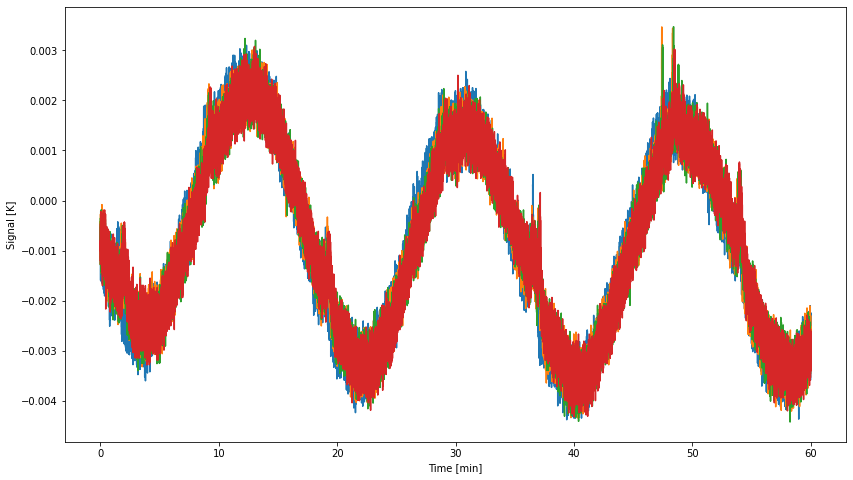

In [111]:
times_min = (sim.observations[0].get_times()-sim.observations[0].start_time.cxcsec)/60.
plt.figure(figsize=(14, 8))
plt.plot(times_min,sim.observations[0].tod[0])
plt.plot(times_min,sim.observations[0].tod[1])
plt.plot(times_min,sim.observations[0].tod[2])
plt.plot(times_min,sim.observations[0].tod[3])

plt.xlabel("Time [min]")
plt.ylabel("Signal [K]")

# Produce a simualted map

We will simulate 2 detectors of 140 GHz MFT. Their definition will be taken from the LiteBIRD Instrument MOdel (IMO) version 1.3 (**new!**), and we will simulate 1 year of observation.

In [127]:
telescope = "MFT"
channel = "M1-140"
detlist = ["001_002_060_45A_140_T",
           "001_003_000_75A_140_B",
          ]

start_time = 0
mission_time_days = 365

imo_version = "v1.3"

# Resolution of the input maps
nside = 256

In [128]:
# This is the folder where the final report with the results of the simulation will be saved
base_path = ".test"

# This loads the full IMO (not only the version specified by `imo_version`!)
imo = lbs.Imo()

# initializing the simulation
sim = lbs.Simulation(
    base_path=base_path,
    start_time=start_time,
    duration_s=mission_time_days * 24 * 3600.0,
)

In [129]:
# Load the definition of the instrument (LFT)
sim.set_instrument(
    lbs.InstrumentInfo.from_imo(
        imo,
        f"/releases/{imo_version}/satellite/{telescope}/instrument_info",
    )
)

dets = []
for n_det in detlist:
    det = lbs.DetectorInfo.from_imo(
        url=f"/releases/{imo_version}/satellite/{telescope}/{channel}/{n_det}/detector_info",
        imo=imo,
    )
    det.sampling_rate_hz = 1.0
    dets.append(det)

[2023-02-14 22:58:33,005 WARNING MPI#0000] Band is not apodized
[2023-02-14 22:58:33,007 WARNING MPI#0000] Band is not apodized


In [130]:
# let's make an input CMB+foreground map
# this sets the parameters for the generation of the map
Mbsparams = lbs.MbsParameters(
    make_cmb=True,
    make_fg=True,
    fg_models=[
        "pysm_synch_0",
        "pysm_freefree_1",
        "pysm_dust_0",
    ],  # set the FG models you want
    nside=nside,
)

mbs = lbs.Mbs(
    simulation=sim,
    parameters=Mbsparams,
    detector_list=dets
)
maps = mbs.run_all()[0]  # generates the map as a dictionary

[2023-02-14 22:58:33,016 INFO MPI#0000] generating and saving cmb simulations
[2023-02-14 22:58:33,126 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2023-02-14 22:58:33,127 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2023-02-14 22:58:33,371 INFO MPI#0000] Access data from /Users/luca/Documents/Universita/litebird/simteam/codes/litebird_sim/notebooks/.test/cmb/0000/cmb_0000_date_230214.fits
[2023-02-14 22:58:33,376 INFO MPI#0000] NSIDE = 256
[2023-02-14 22:58:33,376 INFO MPI#0000] ORDERING = RING in fits file
[2023-02-14 22:58:33,377 INFO MPI#0000] INDXSCHM = IMPLICIT


***************** D
***************** D
***************** D


[2023-02-14 22:58:33,633 INFO MPI#0000] generating and saving fg simulations
[2023-02-14 22:58:33,635 INFO MPI#0000] Retrieve data for pysm_2/synch_t_new.fits (if not cached already)
[2023-02-14 22:58:33,638 INFO MPI#0000] NSIDE = 512
[2023-02-14 22:58:33,638 INFO MPI#0000] ORDERING = RING in fits file
[2023-02-14 22:58:33,639 INFO MPI#0000] INDXSCHM = IMPLICIT
[2023-02-14 22:58:33,854 INFO MPI#0000] Retrieve data for pysm_2/synch_q_new.fits (if not cached already)
[2023-02-14 22:58:33,857 INFO MPI#0000] NSIDE = 512
[2023-02-14 22:58:33,858 INFO MPI#0000] ORDERING = RING in fits file
[2023-02-14 22:58:33,859 INFO MPI#0000] INDXSCHM = IMPLICIT
[2023-02-14 22:58:34,043 INFO MPI#0000] Retrieve data for pysm_2/synch_u_new.fits (if not cached already)
[2023-02-14 22:58:34,045 INFO MPI#0000] NSIDE = 512
[2023-02-14 22:58:34,046 INFO MPI#0000] ORDERING = RING in fits file
[2023-02-14 22:58:34,047 INFO MPI#0000] INDXSCHM = IMPLICIT
[2023-02-14 22:58:34,340 INFO MPI#0000] Retrieve data for pysm

In [135]:
# Generate the quaternions describing how the instrument moves in the Ecliptic reference frame
sim.set_scanning_strategy(
    imo_url=f"/releases/{imo_version}/satellite/scanning_parameters/"
)

sim.create_observations(
    detectors=dets,
    n_blocks_det=1,
    n_blocks_time=1,
)

sim.set_hwp(
    lbs.IdealHWP(
        sim.instrument.hwp_rpm * 2 * np.pi / 60,
    ),  # applies hwp rotation angle to the polarization angle
)
sim.compute_pointings()

In [136]:
sim.fill_tods(maps)
sim.add_noise('white')

In [139]:
binned = lbs.make_bin_map(obs=sim.observations, nside=nside)

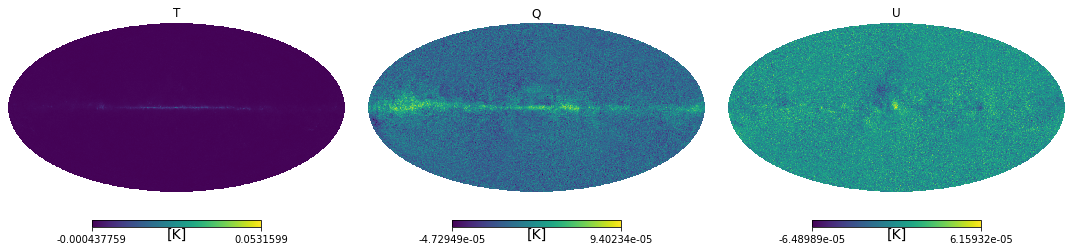

In [144]:
plt.figure(figsize=(15, 8))
hp.mollview(binned[0], sub=131, title="T", unit=r"[K]")
hp.mollview(binned[1], sub=132, title="Q", unit=r"[K]")
hp.mollview(binned[2], sub=133, title="U", unit=r"[K]")